In [1]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta

In [3]:
import os
from datetime import datetime
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama import OllamaEmbeddings
from langchain.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
import sys
import uuid
from psycopg_pool import ConnectionPool
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.checkpoint.sqlite import SqliteSaver

ModuleNotFoundError: No module named 'langchain_ollama'

## Set up environment

In [ ]:
# Set API keys
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

# Optionally, add tracing
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_ENDPOINT"] = 'https://api.smith.langchain.com'
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "llama3-tool-use-agent"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
COHERE_API_KEY = os.getenv("COHERE_API_KEY")


#ASTRA
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_API_ENDPOINT = os.getenv("ASTRA_DB_API_ENDPOINT")
ASTRA_DB_KEYSPACE = os.getenv("ASTRA_DB_KEYSPACE")
load_dotenv()

True

LLM

In [ ]:
# Initialize OpenAI Embeddings
from langchain_openai import ChatOpenAI

GPT3 = 'gpt-3.5-turbo'
GPT4 = "gpt-4o-mini"
NOMIC = 'nomic-embed-text:latest'

embeddings = OllamaEmbeddings(model=NOMIC)

llm=ChatOpenAI(model=GPT3,temperature=0)
# experiment_prefix="sql-agent-gpt4o"
# metadata = "Chinook, gpt-4o base-case-agent"

## Tools

In [ ]:
import requests

@tool
def magic_function(input: int) -> int:
    """Applies a magic function to an input."""
    return input + 2

@tool
def get_coordinates(city_name: str, state: str) -> tuple:
    """
    Get the latitude and longitude for a given city and state.
    
    Args:
    - city_name (str): The name of the city.
    - state (str): The name of the state.
    
    Returns:
    - tuple: A tuple containing the latitude and longitude of the location.
    """
    geolocator = Nominatim(user_agent="weather_api")
    location = geolocator.geocode(f"{city_name}, {state}")
    if location:
        return location.latitude, location.longitude
    else:
        return None

@tool
def fetch_weather_data(city_name: str, state: str, date_query: str):
    """
    Fetch weather data for a given city, state, and date query.
    
    Args:
    - city_name (str): The name of the city.
    - state (str): The name of the state.
    - date_query (str): The date query which can be "today", "yesterday", "last 10 days", 
                        "last 30 days", "last three months", or specific date range "YYYY-MM-DD/YYYY-MM-DD".
    
    Returns:
    - dict: A dictionary containing location information and a DataFrame of the weather data.
    """
    coordinates = get_coordinates(city_name, state)
    if not coordinates:
        return {"error": "City not found"}
    
    lat, lon = coordinates

    # Calculate dates based on query
    end_date = datetime.now().strftime("%Y-%m-%d")
    
    if date_query.lower() == "today":
        start_date = end_date
    elif date_query.lower() == "yesterday":
        start_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
        end_date = start_date
    elif "last" in date_query.lower():
        if "10 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(10)).strftime("%Y-%m-%d")
        elif "30 days" in date_query.lower():
            start_date = (datetime.now() - timedelta(30)).strftime("%Y-%m-%d")
        elif "three months" in date_query.lower():
            start_date = (datetime.now() - timedelta(90)).strftime("%Y-%m-%d")
        else:
            return {"error": "Invalid date query"}
    else:
        try:
            # Specific date range
            start_date, end_date = date_query.split('/')
            # Validate dates
            datetime.strptime(start_date, "%Y-%m-%d")
            datetime.strptime(end_date, "%Y-%m-%d")
        except ValueError:
            return {"error": "Invalid date format. Use YYYY-MM-DD or predefined ranges."}

    # Setup the Open-Meteo API client with cache and retry on error
    cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
    retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
    openmeteo = openmeteo_requests.Client(session=retry_session)

    # Define the API endpoint and parameters
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m"
    }

    # Fetch the weather data
    responses = openmeteo.weather_api(url, params=params)
    response = responses[0]

    # Display location information
    location_info = {
        "Coordinates": f"{response.Latitude()}°N {response.Longitude()}°E",
        "Elevation": f"{response.Elevation()} m asl",
        "Timezone": f"{response.Timezone()} {response.TimezoneAbbreviation()}",
        "Timezone difference to GMT+0": f"{response.UtcOffsetSeconds()} s"
    }

    # Process hourly data
    hourly = response.Hourly()
    hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

    # Get every sixth hour
    time_indices = list(range(0, len(hourly_temperature_2m), 6))
    hourly_temperature_2m_6hr = hourly_temperature_2m[time_indices]

    # Generate dates for every sixth hour
    hourly_data = {
        "date": pd.date_range(
            start=pd.to_datetime(hourly.Time(), unit="s", utc=True),
            periods=len(hourly_temperature_2m_6hr),
            freq='6H'
        ),
        "temperature_2m": hourly_temperature_2m_6hr
    }

    hourly_dataframe = pd.DataFrame(data=hourly_data)

    return {"location_info": location_info, "weather_data": hourly_dataframe.to_dict(orient='records')}



@tool
def fetch_electricity_prices(year: str, month: str, day: str, region: str) -> str:
    """Fetches electricity prices for a given date and region."""
    import requests
    url = f"https://www.hvakosterstrommen.no/api/v1/prices/{year}/{month}-{day}_{region}.json"
    response = requests.get(url)
    if response.status_code == 200:
        return json.dumps(response.json(), indent=4)
    else:
        return f"Error fetching data: {response.status_code}"

@tool
def web_search(input: str) -> str:
    """Runs web search."""
    web_search_tool = TavilySearchResults()
    docs = web_search_tool.invoke({"query": input})
    return docs

# @tool
# def image2text(image_url: str, prompt: str) -> str:
#     """generate text for image_url based on prompt."""
#     input = {
#         "image": image_url,
#         "prompt": prompt
#     }
#     output = replicate.run(
#         "yorickvp/llava-13b:b5f612031823083fd4b6dda3e32fd8a0e75dc39d8a4191bb742157fb",
#         input=input
#     )
#     return "".join(output)
# 
# @tool
# def text2speech(text: str) -> int:
#     """convert text to a speech."""
#     output = replicate.run(
#         "cjwbw/seamless_communication:668a4fec05a8871a54e5fe8d45df25ec4c794dd43169b9a11562309b2d45873b0",
#         input={
#             "task_name": "T2ST (Text to Speech translation)",
#             "input_text": text,
#             "input_text_language": "English",
#             "max_input_audio_length": 60,
#             "target_language_text_only": "English",
#             "target_language_with_speech": "English"
#         }
#     )
#     return output

custom_tools = [magic_function, 
                web_search, 
                fetch_electricity_prices, 
                fetch_weather_data,
                get_coordinates]

print(magic_function)
magic_function.args_schema

name='magic_function' description='Applies a magic function to an input.' args_schema=<class 'pydantic.v1.main.magic_functionSchema'> func=<function magic_function at 0x7c0a5cd9dee0>


pydantic.v1.main.magic_functionSchema

## SQL Database

In [ ]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///test.db")

print(db.dialect)
print(db.get_usable_table_names())

sqlite
['checkpoints', 'prices', 'products']


## SQL tools

In [5]:
import json
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, MessageGraph
from langgraph.prebuilt.tool_node import ToolNode
from langchain_core.messages import AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import tool

# SQL toolkit
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

# Define the SQL instructions
sql_instructions = """
SQL DATABASE INSTRUCTIONS:
- Start by reviewing the tables in the database to understand what you can query.
- Query the schema of relevant tables.
- Write and double-check your query based on the table schema.
- Limit your query to at most 5 results unless specified otherwise.
- Order results by relevant columns to return the most interesting examples.
- Query only relevant columns for the question.
- If an error occurs, rewrite the query and try again.
- Use the check_result tool to verify query results.
- If the query returns no results, rethink the schema and try again.
- DO NOT perform DML operations (INSERT, UPDATE, DELETE, DROP, etc.).
"""

# Query checking
query_check_system = """You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Execute the correct query with the appropriate tool."""
query_check_prompt = ChatPromptTemplate.from_messages([("system", query_check_system), ("user", "{query}")])
query_check = query_check_prompt | llm

@tool
def check_query_tool(query: str) -> str:
    """
    Use this tool to double check if your query is correct before executing it.
    """
    return query_check.invoke({"query": query}).content

# Query result checking
query_result_check_system = """You are grading the result of a SQL query from a DB.
- Check that the result is not empty.
- If it is empty, instruct the system to re-try!"""
query_result_check_prompt = ChatPromptTemplate.from_messages([("system", query_result_check_system), ("user", "{query_result}")])
query_result_check = query_result_check_prompt | llm

@tool
def check_result(query_result: str) -> str:
    """
    Use this tool to check the query result from the database to confirm it is not empty and is relevant.
    """
    return query_result_check.invoke({"query_result": query_result}).content

# Combine all SQL tools and instructions
sql_tools_with_instructions = sql_tools + [check_query_tool, check_result]

tools = custom_tools + sql_tools_with_instructions

ModuleNotFoundError: No module named 'langgraph.checkpoint.sqlite'

In [4]:
from datetime import datetime
from langchain.prompts import ChatPromptTemplate

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", 
         "You are a helpful assistant with tools for (1) web search, (2) weather data fetch, and (3) electricity price fetch. "
         "Use web search for real-time queries and current events, weather data fetch for weather-related questions, and electricity price fetch for price-related queries. "
         "For database questions, follow SQL instructions. Determine the appropriate tool based on the question, fetch the necessary data, and return the answer. "
         "Current time: {time}."),
        ("placeholder", "{messages}"),
        ("system",
         """
         ROLE:
         You interact with various data sources using specific tools to answer questions accurately.
         GOAL:
         Use the appropriate tool for the input question, retrieve data, and provide a relevant answer.
         INSTRUCTIONS:
         - Use tools only for their specified operations.
         - Construct your final answer using tool outputs.
         - For weather questions, use the weather data fetch tool.
         - For electricity price queries, use the electricity price fetch tool.
         - For real-time information, use the web search tool.
         - For database questions, follow SQL instructions.
         """)
    ]
).partial(time=datetime.now())

# LLM chain
#llm = ChatGroq(temperature=0, model="llama3-70b-8192")
assistant_runnable = primary_assistant_prompt | llm.bind_tools(tools)

NameError: name 'llm' is not defined

In [ ]:
question = "What is magic_function(3)?"
payload = assistant_runnable.invoke({"messages": [("user", question)]})
payload.tool_calls

[{'name': 'magic_function',
  'args': {'input': 3},
  'id': 'call_9znIrSH5MkzkkiPV6kPtoJjO',
  'type': 'tool_call'}]

In [ ]:
question = "What is the capital of the US?"
payload = assistant_runnable.invoke({"messages": [("user", question)]})
payload.tool_calls

[{'name': 'web_search',
  'args': {'input': 'Capital of the United States'},
  'id': 'call_G83iCjXqnig8o4mYSInnDg6O',
  'type': 'tool_call'}]

In [11]:
question = "Hvilket produkt er billigst fra test databasen? Og Hvilket merke er det?"
payload = assistant_runnable.invoke({"messages": [("user", question)]})
payload.tool_calls

[{'name': 'sql_db_query',
  'args': {'query': 'SELECT product_name, brand, MIN(price) AS cheapest_price FROM test GROUP BY product_name ORDER BY cheapest_price LIMIT 1'},
  'id': 'call_Gb3aQE5akI5bUjXXu46ksvt2',
  'type': 'tool_call'}]

## Memory/State

In [12]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages

# Define the State type
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [13]:
import faiss

from langchain_community.docstore import InMemoryDocstore
from langchain_community.vectorstores import FAISS


embedding_size = 384 # Dimensions of the OpenAIEmbeddings
index = faiss.IndexFlatL2(embedding_size)
embedding_fn = embeddings.embed_query
vectorstore = FAISS(embedding_fn, index, InMemoryDocstore({}), {})

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


## The embedding saver

## The assistant

In [14]:
from langchain_core.runnables import RunnableLambda, RunnableConfig, Runnable

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            # Invoke the tool-calling LLM
            result = self.runnable.invoke(state)
            # If it is a tool call -> response is valid
            # If it has meaningful text -> response is valid
            # Otherwise, we re-prompt it because response is not meaningful
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                # Then we re-try
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

# Tool
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

# Utilities
def _print_event(event: dict, _printed: set, max_length=1500) -> None:
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)
            

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"]
            ) for tc in tool_calls
        ]
    }


assistant = Assistant(assistant_runnable)

## The graph

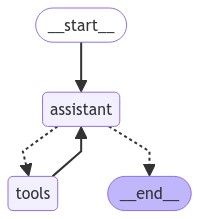

In [15]:
# Graph
builder = StateGraph(State)

builder.add_node("assistant", RunnableLambda((assistant)))
builder.add_node("tools", create_tool_node_with_fallback(tools))

# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
    # 'Tools' calls one of our tools. END causses the graph to terminate(and repond to the user)
        {"tools": "tools", END: END},
)
builder.add_edge("tools", "assistant")


# The checkpointer lets the graph persist its state
memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile()


try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {e}")

## Test

In [16]:
questions = [
    "What is magic_function(3)",
    "What was the weather at Lillehammer yesterday?",
]

_printed = set()
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        "thread_id": thread_id,  # Checkpoints are accessed by thread_id
    }
}

events = graph.stream(
    {"messages": [("user", questions[1])]}, config, stream_mode="values"
)

for event in events:
    _print_event(event, _printed)

================================ Human Message =================================

What was the weather at Lillehammer yesterday?
================================== Ai Message ==================================
Tool Calls:
  fetch_weather_data (call_jebc47X1xo9xUtTks8dI9pbz)
 Call ID: call_jebc47X1xo9xUtTks8dI9pbz
  Args:
    city_name: Lillehammer
    state: Norway
    date_query: yesterday
================================= Tool Message =================================
Name: fetch_weather_data

Error: AttributeError("'str' object has no attribute 'parent_run_id'")
 Please fix your mistakes.


/home/teodorrk/Projects/Langchain_agent/.myvenv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


================================== Ai Message ==================================
Tool Calls:
  fetch_weather_data (call_qkcKCAR1LAFUz5vdGcnPAjmR)
 Call ID: call_qkcKCAR1LAFUz5vdGcnPAjmR
  Args:
    city_name: Lillehammer
    state: Norway
    date_query: yesterday
================================= Tool Message =================================
Name: fetch_weather_data

Error: AttributeError("'str' object has no attribute 'parent_run_id'")
 Please fix your mistakes.
================================== Ai Message ==================================
Tool Calls:
  fetch_weather_data (call_U2omccPPfmhydwq4cORGuT85)
 Call ID: call_U2omccPPfmhydwq4cORGuT85
  Args:
    city_name: Lillehammer
    state: Oppland
    date_query: yesterday
================================= Tool Message =================================
Name: fetch_weather_data

Error: AttributeError("'str' object has no attribute 'parent_run_id'")
 Please fix your mistakes.
================================== Ai Message =============

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.